## Temporal Features
The temporal features (time domain features), which are simple to extract and have easy physical interpretation, like: the energy of signal, zero crossing rate, maximum amplitude, minimum energy, etc.

### Zero cross rate
Often used to classify percussive sounds. A large number of zero crossings implies that there is no dominant low-frequency oscillation. 

## Spectral Features
The spectral features (frequency based features), which are obtained by converting the time based signal into the frequency domain using the Fourier Transform, like: mfcc, fundamental frequency, frequency components, spectral centroid, spectral flux, spectral density, spectral roll-off, etc. **These features can be used to identify the notes, pitch, rhythm, and melody.**  

### spectral centroid
The [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid#:~:text=The%20spectral%20centroid%20is%20a,of%20brightness%20of%20a%20sound.) is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of **brightness** of a sound. Because the spectral centroid is a good predictor of the "brightness" of a sound, it is widely used in digital audio and music processing as an automatic measure of musical timbre.

### spectral spread 
https://www.sciencedirect.com/topics/engineering/spectral-centroid

### spectral bandwidth
Bandwidth is the difference between the upper and lower frequencies in a continuous band of frequencies. It is typically measured in hertz, and depending on context, may specifically refer to passband bandwidth or baseband bandwidth. Passband bandwidth is the difference between the upper and lower cutoff frequencies of, for example, a band-pass filter, a communication channel, or a signal spectrum. Baseband bandwidth applies to a low-pass filter or baseband signal; the bandwidth is equal to its upper cutoff frequency.

### spectral flatness 
Spectral flatness is an indication of the peakiness of the spectrum. Spectral flatness is typically measured in decibels, and provides a way to quantify **how tone-like a sound is, as opposed to being noise-like.** A higher spectral flatness indicates noise, while a lower spectral flatness indicates tonality. Tonality, in music, principle of organizing musical compositions around a central note, the tonic. Generally, any Western or non-Western music periodically returning to a central, or focal, tone exhibits tonality

### spectral rolloff
This is a measure of the amount of the right-skewedness of the power spectrum. The spectral roll off point is the fraction of bins in the power spectrum at which 85% of the power is at lower frequencies. That is, the roll-off is the frequency below which 85% of accumulated spectral magnitude is concentrated. Like the centroid, it takes on higher values for right-skewed spectra.

The spectral rolloff point has been used to distinguish between voiced and unvoiced speech, speech/music discrimination, music genre classification, acoustic scene recognition, and music mood classification. 

In [3]:
%matplotlib inline
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import sklearn
import scipy as sp
import scipy.signal as spsig
from scipy.fftpack import fft
import novainstrumentation as ni
from sklearn import preprocessing
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
from dataclasses import dataclass

['sax_G4_12.wav', 'sine-1000.wav']
--------------------------------------------------------------------------------------------------------
sax_G4_12.wav
	N = 464149 samples  | Dur = 10.524921 seconds  | Fs = 44100 Hz
	audata_over_wind = (4096, 904) (win_len , n_windows)

	ZCR: mean = 0.03872  | std = 0.02292934012388621
	RMS: mean = 0.03872  | std = 0.003948428243411742

	SPECTRAL
	CENTROID: mean = 2224.14725  | std = 339.22604001223317
	SPREAD: 
	FLATNESS: mean = 2e-05  | std : 9.83252e-06
	BW: mean = 1629.63236  | std = 307.3025639456224 



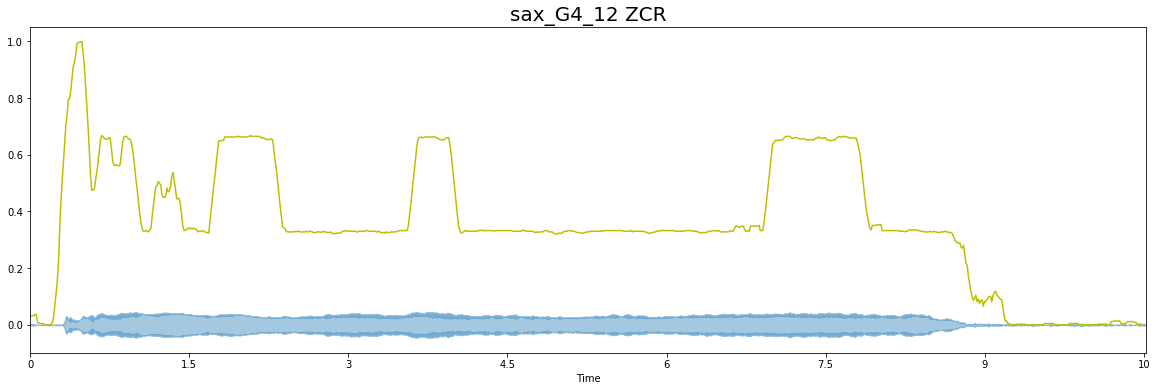

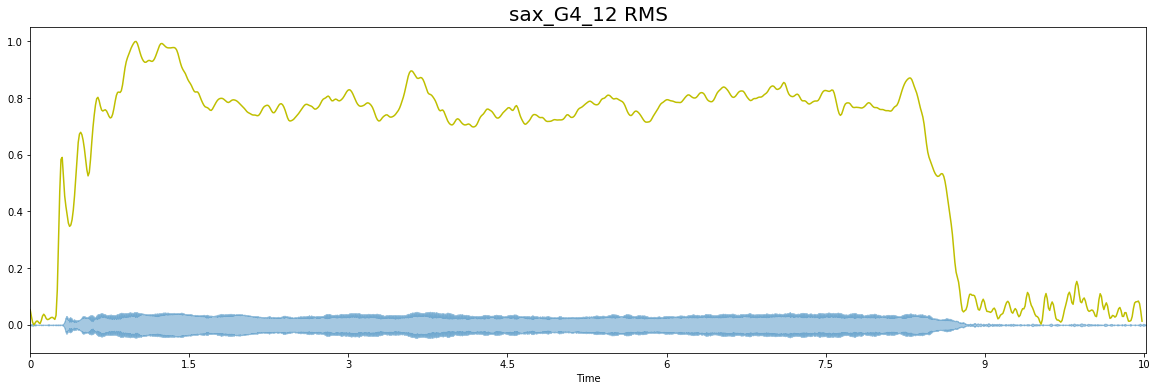

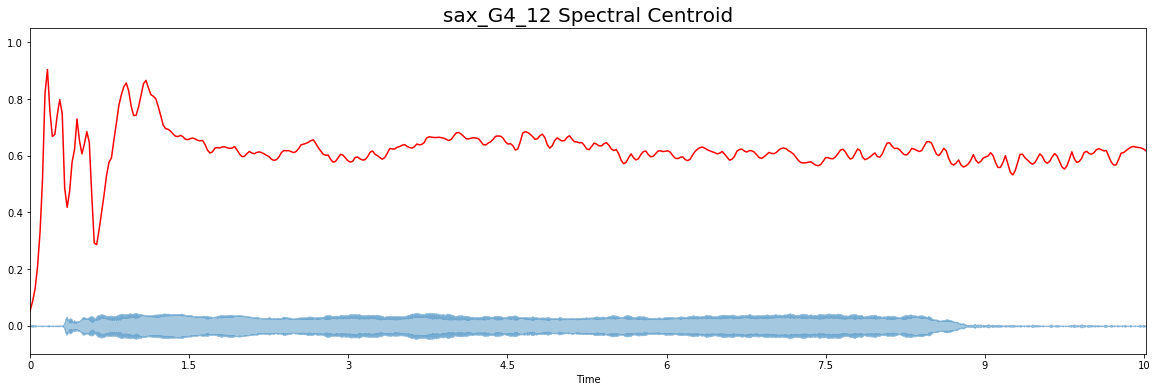

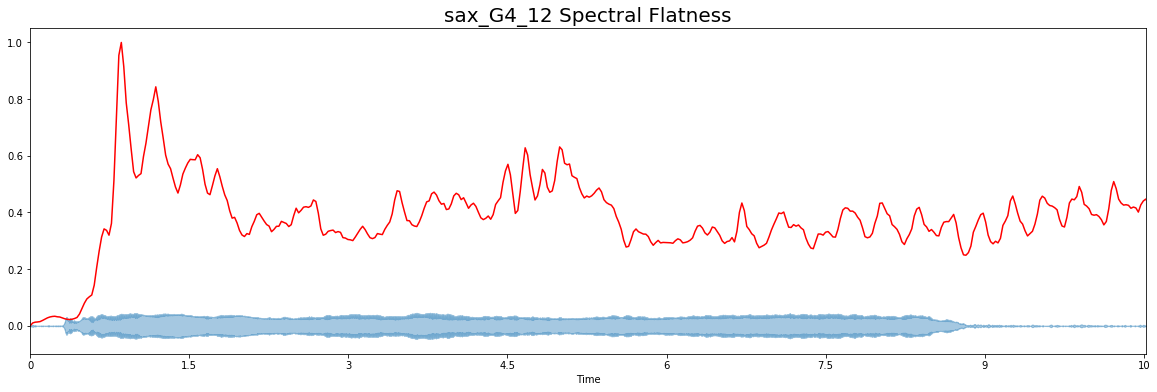

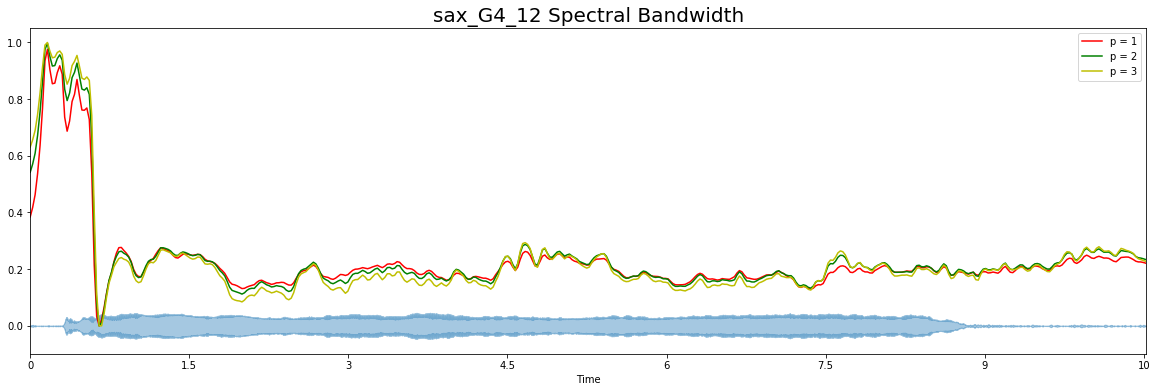

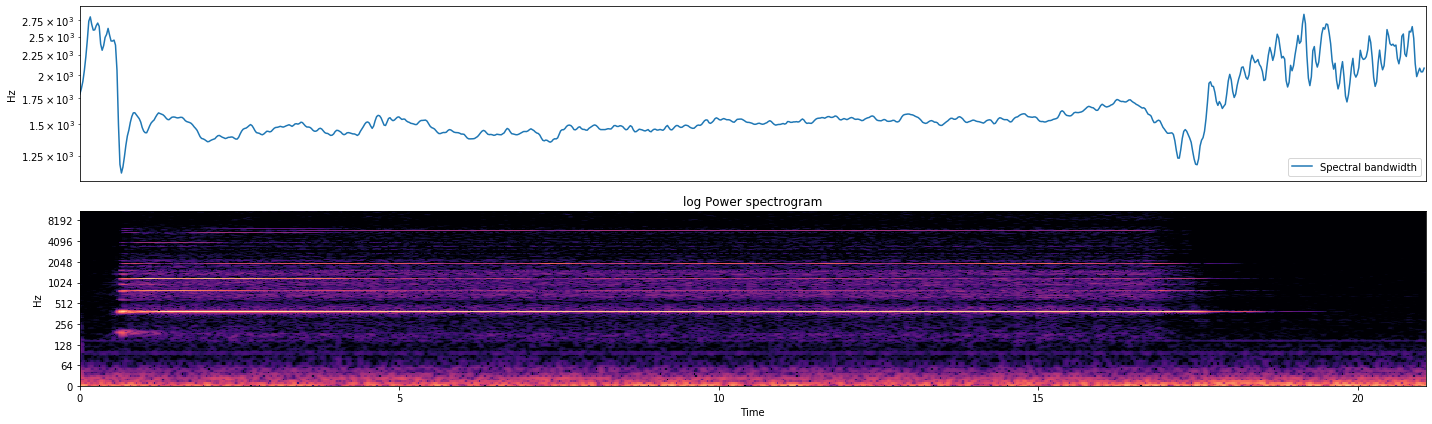

--------------------------------------------------------------------------------------------------------
sine-1000.wav
	N = 88200 samples  | Dur = 2.000000 seconds  | Fs = 44100 Hz
	audata_over_wind = (4096, 168) (win_len , n_windows)

	ZCR: mean = 0.04467  | std = 0.001402432928757461
	RMS: mean = 0.04467  | std = 0.0023124129434024363

	SPECTRAL
	CENTROID: mean = 1028.62193  | std = 1.777367866401786
	SPREAD: 
	FLATNESS: mean = 0.0  | std : 3.4934402e-08
	BW: mean = 350.4931  | std = 11.403176319827296 



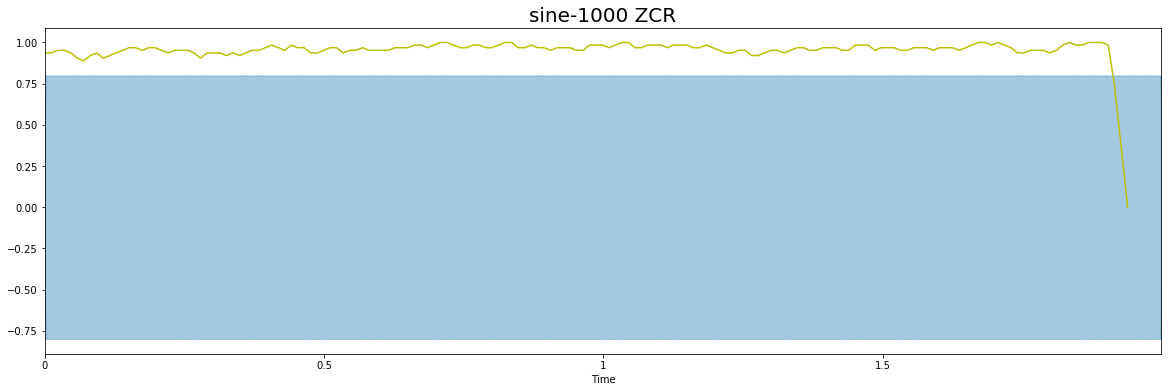

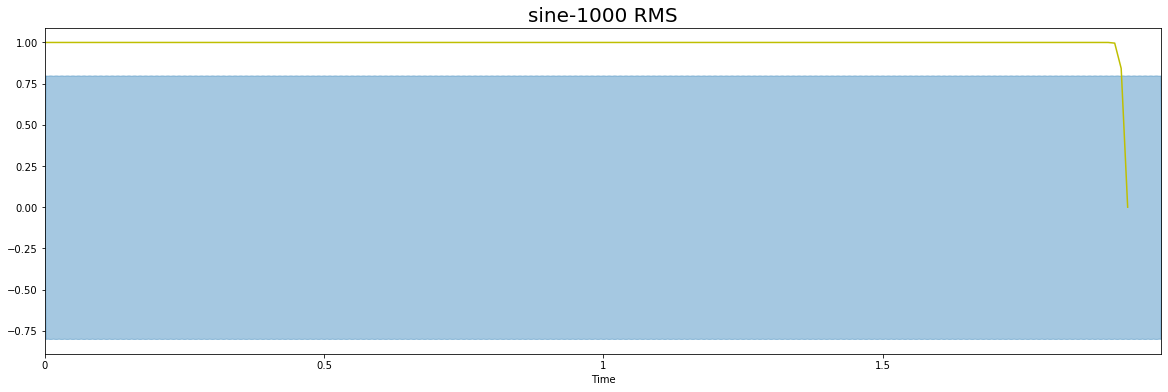

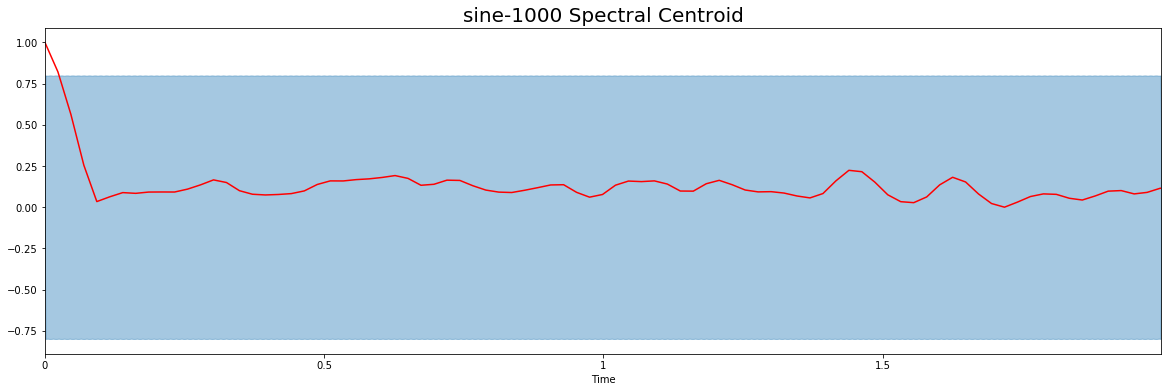

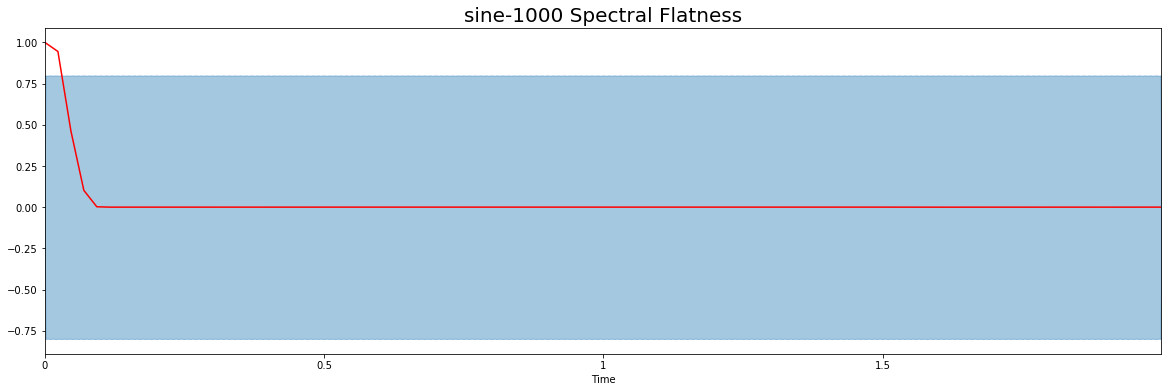

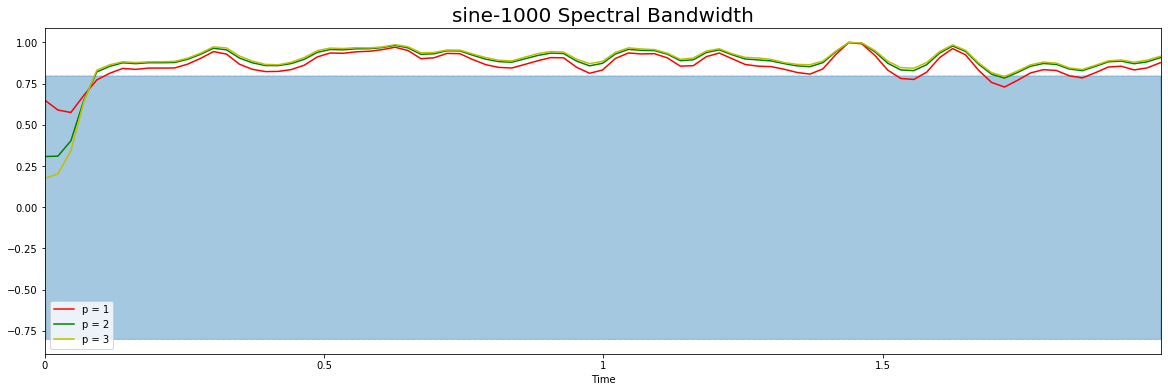

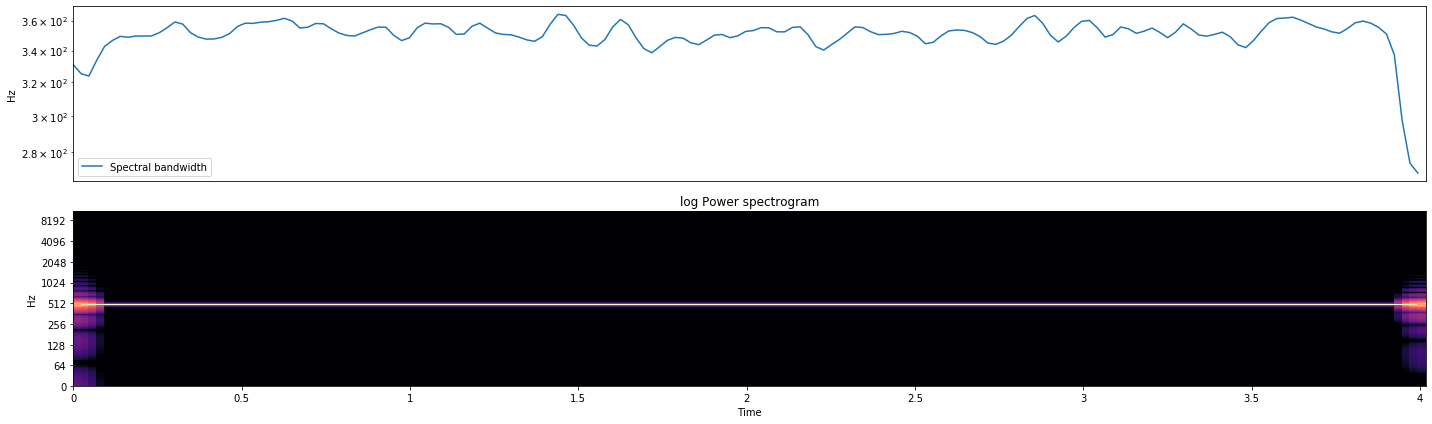

In [8]:
WINDOW_LEN = 4096
WINDOW_OVERLAP = WINDOW_LEN * (3/4)
WINDOW_STEP = 512 #int(WINDOW_LEN - WINDOW_OVERLAP)
WINDOW = np.hanning(WINDOW_LEN)
save_img_path = './img/'

@dataclass
class Data:
    audata = None
    audata_overwin = None
    
    t = None
    Fs = None
    N = None
    nwin = None
    
    f = None #filename w/out extension
    
    rms = None
    zcr = None
    spec_cent = None
    spec_bw_1 = None
    spec_flat = None
    
data = Data()


#https://rramnauth2220.github.io/blog/posts/code/200525-feature-extraction.html
#https://github.com/musikalkemist/AudioSignalProcessingForML/blob/master/9-%20RMS%20energy%20and%20zero-crossing%20rate/RMS%20Energy%20and%20Zero-Crossing%20Rate.ipynb


def plot_audio( x , y ):
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.plot(x,y, c='g')
    plt.xlim([min(t), max(t)])
    plt.xlabel('Time (seconds)');

def load_files():
    """Finds and loads files from within folder structure."""
    input_path = './audio/input/'

    files = [x for x in os.listdir(input_path) if x != '.ipynb_checkpoints']
    print(files)
    return files
      
    
################################################ SPEC ################################################
#python_speech_features.sigproc.framesig does the same in 1 line
def overlap_n_window(X):
    window_len, window_step = map(int, (WINDOW_LEN, WINDOW_STEP))
    if window_len % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_len - len(X) % window_len)) #478
    X = np.hstack((X, append)) #22050 + 478 = 22528 ; len(X) multiplo de WINDOW_LEN
    
    ws = window_len
    ss = window_step
    a = X

    valid = len(a) - ws #retira a primeira janela
    nw = (valid) // ss #n janelas que vai iterar
    X_win = np.ndarray((ws,nw),dtype = a.dtype)
    
    print("\taudata_over_wind =" , np.shape(X_win) , "(win_len , n_windows)")
    
    for i in range(nw):
        start = i * ss
        stop = start + ws
        #get X windowed / 1 janela por coluna
        X_win[:,i] = a[start : stop] * WINDOW
    
    return X_win , nw

def stft( data_ow , compute_onesided=True ):
    """
    Compute STFT for 1D real valued input X
    """
    
    n_win = np.shape(data_ow)[1]
    X_stft1 = np.zeros(( WINDOW_LEN, n_win), dtype='complex')
    
    for m in range(n_win):
        #fft signal
        X = np.fft.fft(data_ow[:,m])
        #save
        X_stft1[:, m] = X    
        
    if compute_onesided:
        K = 1 + WINDOW_LEN // 2
        X_stft1 = X_stft1[0:K, :]
    
    #if compute_onesided:
    #    cut = WINDOW_LEN // 2
    #X_stft2 = np.fft.fft(data_ow)[:cut,:]
    
    print("audata_stft :",np.shape(X_stft1) )
    return X_stft1

def plot_stft( spec , N , Fs ):
    Y = np.abs(spec) ** 2
    eps = np.finfo(float).eps
    Y_db = 10 * np.log10(Y + eps)

    T_coef = np.arange(spec.shape[1]) * WINDOW_STEP / Fs #num linhas
    F_coef = np.arange(spec.shape[0]) * Fs / WINDOW_LEN

    fig = plt.figure(figsize=(20, 10))

    gs = matplotlib.gridspec.GridSpec(3, 2, height_ratios=[1, 2, 2], width_ratios=[100, 2])
    ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(1,6)]

    ax2.set_visible(False)

    left = min(T_coef)
    right = max(T_coef) + N / Fs
    lower = min(F_coef)
    upper = max(F_coef)

    #LINEAR
    im1 = ax3.imshow(Y, origin='lower', aspect='auto', 
                     extent=[left, right, lower, upper])
    im1.set_clim([0, 1000])
    ax3.set_ylim([0, 8000])
    ax3.set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im1, cax=ax4)
    ax4.set_ylabel('Magnitude (linear)', rotation=90)
    
    #LOG
    im2 = ax5.imshow(Y_db, origin='lower', aspect='auto', 
                     extent=[left, right, lower, upper])
    im2.set_clim([-30, 20])
    ax5.set_ylim([0, 8000])
    ax5.set_xlabel('Time (seconds)')
    ax5.set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im2, cax=ax6)
    ax6.set_ylabel('Magnitude (dB)', rotation=90)
    plt.tight_layout()

################################################ RMS ################################################
def generate_rms():
    x = data.audata_overwin
    rms = np.zeros( data.nwin);
    
    for i in range(data.nwin):
        rms[i] = np.sqrt(np.mean(x[:,i]**2))
       
    return rms

def generate_rms_lib_replica():
    rmse = []
    # calculate rmse for each frame
    for i in range(0, len(data.audata), WINDOW_STEP): 
        rmse_current_frame = np.sqrt(sum(data.audata[i:i+WINDOW_LEN]**2) / WINDOW_LEN)
        rmse.append(rmse_current_frame)
    return np.array(rmse) 
    
def plot_rms(rms_lib = False):
    
    data.rms = generate_rms()
   
    frames = range(len(data.rms))
    t_rms = librosa.frames_to_time(frames, sr = data.Fs , hop_length=WINDOW_STEP)
    
    plt.figure(figsize=(20,6))
    plt.title(data.f + " RMS", fontsize=20)
    librosa.display.waveplot(data.audata, sr=data.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(t_rms,normalize(data.rms),color='y',label='rms')
    #db
    #plt.plot(t_rms, 10*np.log(rms) , color='g') PLOT XSCALE IN LOG
   
    plt.savefig(''.join([save_img_path, data.f, '_rms.png']), format='png')

    if rms_lib:
        rms_lr = generate_rms_lib_replica()
        
        #RMS LIBROSA REPLICA
        framess = range(len(rms_lr))
        t_rmss = librosa.frames_to_time(framess, sr = data.Fs , hop_length=WINDOW_STEP)
        plt.plot(t_rmss,rms_lr,color='b',label='librosa mimica')
        plt.legend(loc='best')

        #LIBROSA
        rms_lib = librosa.feature.rms(data.audata , frame_length = WINDOW_LEN , hop_length = WINDOW_STEP)[0]
        frames = range(len(rms_lib))
        t_lib = librosa.frames_to_time(frames, sr = data.Fs , hop_length=WINDOW_STEP)
        plt.plot(t_lib,rms_lib,color='r',label='librosa')
        plt.legend(loc='best')
           
################################################ ZCR ################################################
def generate_zcr():
    
    zcr = np.zeros( data.nwin );
    zcr2 = np.zeros( data.nwin );
    
    #zero_crossings = numpy.where(numpy.diff(numpy.sign(a)))[0] outputs array with indices where it crossed
    x = data.audata_overwin
    
    for i in range(data.nwin):
             
        zcr_cont = 0
        for j in range(np.shape(x)[0] - 1): #np.shape(x)[0] = window_len
            if x[j,i] * x[j+1,i] < 0 :
                zcr_cont = zcr_cont + 1
        zcr[i] = zcr_cont / WINDOW_LEN
        
        
        zcr2[i] = np.sum(np.diff(np.sign(x[:,i])) != 0, axis=0) / WINDOW_LEN
    
    return zcr 

def plot_zcr( zcr_lib = None ):

    data.zcr = generate_zcr()
    
    #MINE
    frames = range(len(data.zcr))
    t_zcr = librosa.frames_to_time(frames, sr = data.Fs , hop_length=WINDOW_STEP)
    
    plt.figure(figsize=(20,6))
    plt.title(data.f + " ZCR", fontsize=20)
    librosa.display.waveplot(data.audata, sr=data.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(t_zcr,normalize(data.zcr),color='y',label='og method 1')
    
    #LIBROSA
    if zcr_lib is not None:
        framess = range(len(zcr_lib))
        t_zcr_lib = librosa.frames_to_time(framess, sr = data.Fs , hop_length=WINDOW_STEP)
        plt.plot(t_zcr_lib,zcr_lib,color='r',label='librosa')
        plt.legend(loc='best')

    
    plt.savefig(''.join([save_img_path, data.f, '_zcr.png']), format='png')

################################################ SPEC_AUX ################################################
#Define a helper function to normalize the spectral centroid for visualization:
def normalize(x, axis=0):
    """It takes an array in as an input and normalizes its values between 0 and 1."""
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def moving_average(a, n=30) :
    """Creates a moving average to apply smoothing to the spectral centroid plot."""
    #self.window = n
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
        
    return ret[n - 1:] / n


################################################ SPECENTROID ################################################

def spectral_centroid(mel = False ,  db = False , normal = True):
    """computes the spectral centroid over a mel spectrogram, over a db spectrogram or normalized over the waveform """
    
    #normalize
    if normal:
        data.spec_cent = librosa.feature.spectral_centroid(data.audata , sr=data.Fs, n_fft=WINDOW_LEN, hop_length=WINDOW_STEP)[0]
        
        frames = range(len(data.spec_cent)) #Compute the time variable for visualization
        t = librosa.frames_to_time(frames)

        plt.figure(figsize=(20,6))
        plt.title(data.f + " Spectral Centroid", fontsize=20)
        librosa.display.waveplot(data.audata, sr=data.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
        plt.plot(t, normalize(data.spec_cent), color='r') # normalize for visualization purposes
        plt.savefig(''.join([save_img_path, data.f, '_norm_centroid.png']), format='png')

    if mel or db:  
        cent = librosa.feature.spectral_centroid(y=data.audata , sr=data.Fs, n_fft=WINDOW_LEN, hop_length=WINDOW_STEP)
        cent = moving_average(spec_cent)
        times = librosa.times_like(spec_cent)
    
    #MEL
    if mel: 
        fig, ax = plt.subplots(figsize=(20,10))
        
        S = librosa.feature.melspectrogram(y=data.audata , sr=data.Fs, n_mels=128,fmax=20000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=data.Fs,fmax=20000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        
        ax.plot(times, spec_cent.T, label=' Spectral centroid', color='k')
        ax.set(title=f'Mel-frequency spectrogram {data.f}')
        
        plt.savefig(''.join([save_img_path, data.f , '_mel_centroid.png']), format='png')

    #DB
    if db:
        fig, ax = plt.subplots(figsize=(20,10))
        
        D = librosa.stft(y=data.audata , n_fft=WINDOW_LEN, hop_length=WINDOW_STEP)
        S, phase = librosa.magphase(D)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),sr=data.Fs,
                                 y_axis='log', x_axis='time', ax=ax)
        
        ax.plot(times, spec_cent.T, label=' Spectral centroid', color='k')
        ax.legend(loc='upper right')
        ax.set(title=f'log Power spectrogram {data.f}')

        plt.savefig(''.join([save_img_path, data.f, '_db_centroid.png']), format='png')

def spectral_flat():
    """A way to quantify how tone-like a sound is, as opposed to being noise-like"""
    data.spec_flat = librosa.feature.spectral_flatness(y=(data.audata + 0.01),n_fft=WINDOW_LEN,hop_length=WINDOW_STEP)[0]
    
    frames = range(len(data.spec_flat)) #Compute the time variable for visualization
    t = librosa.frames_to_time(frames)

    plt.figure(figsize=(20,6))
    plt.title(data.f + " Spectral Flatness", fontsize=20)
    librosa.display.waveplot(data.audata, sr=data.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(t, normalize(data.spec_flat), color='r') # normalize for visualization purposes

    plt.savefig(''.join([save_img_path, data.f, '_norm_flatness.png']), format='png')

def spectral_bw(db = False):
    data.spec_bw_1 = librosa.feature.spectral_bandwidth(y=data.audata,n_fft=WINDOW_LEN,hop_length=WINDOW_STEP)[0]
    spec_bw_2 = librosa.feature.spectral_bandwidth(y=data.audata,n_fft=WINDOW_LEN,hop_length=WINDOW_STEP, p=3)[0]
    spec_bw_3 = librosa.feature.spectral_bandwidth(y=data.audata,n_fft=WINDOW_LEN,hop_length=WINDOW_STEP, p=4)[0]

    frames = range(len(data.spec_bw_1)) #Compute the time variable for visualization
    t = librosa.frames_to_time(frames)
    
    plt.figure(figsize=(20,6))
    plt.title(data.f + " Spectral Bandwidth", fontsize=20)
    librosa.display.waveplot(data.audata, sr=data.Fs, alpha=0.4)
    plt.plot(t, normalize(data.spec_bw_1), color='r')
    plt.plot(t, normalize(spec_bw_2), color='g')
    plt.plot(t, normalize(spec_bw_3), color='y')
    plt.legend(('p = 1', 'p = 2', 'p = 3'))
    
    #if db:
        #    fig, ax = plt.subplots(figsize=(20,10))
        #    
        #    S = np.abs(librosa.stft(y=data.audata , n_fft=WINDOW_LEN, hop_length=WINDOW_STEP))     
        #    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),sr=data.Fs,y_axis='log', x_axis='time', ax=ax)
        #    #fig.colorbar(format='%+2.0f dB')
        #    #fig.title('Power spectrogram')
        #    
        #    ax.plot(t, data.spec_bw_1.T, label=' Spectral BW', color='w')
        #    ax.legend(loc='upper right')
        #    ax.set(title=f'log Power spectrogram {data.f}')
        #
        #    plt.savefig(''.join([save_img_path, data.f, '_db_centroid.png']), format='png')
    
    if db:
        S = np.abs(librosa.stft(y=data.audata , n_fft=WINDOW_LEN, hop_length=WINDOW_STEP))  
        plt.figure(figsize=(20,6))
        plt.subplot(2, 1, 1)
        plt.semilogy(data.spec_bw_1.T, label='Spectral bandwidth')
        plt.ylabel('Hz')
        plt.xticks([])
        plt.xlim([0, data.spec_bw_1.shape[-1]])
        plt.legend()
        plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
        plt.title('log Power spectrogram')
        plt.tight_layout()


        
def main():
    
    files = load_files()
    
    for fwav in files:
        
        #EXTRACT DATA FROM AUDIO
        print('--------------------------------------------------------------------------------------------------------\n' + fwav )
        data.f = fwav.split('.',2)[0]
        data.audata , data.Fs = librosa.load('./audio/input/' + fwav, sr = None )
        
        data.N = np.shape(data.audata)[0]
        data.dur = data.N / data.Fs
        data.t = np.arange(data.N) / data.Fs #fs = nsamples / segundo
        print("\tN = %d samples" %data.N , " | Dur = %f seconds" %data.dur , " | Fs = %d Hz" %data.Fs)

        #PLOT AUDIO SIGNAL
        #plot_audio(t , audata)
        
        #OVERLAP AND WINDOW OF THE SIGNAL INTO MATRIX 
        data.audata_overwin , data.nwin = overlap_n_window(X = data.audata)
        
        #ZCR
        plot_zcr()
        #zcr_lib = librosa.feature.zero_crossing_rate(data.audata , frame_length = WINDOW_LEN , hop_length = WINDOW_STEP)[0]
        #print("zcr_lib",np.shape(zcr_lib),"zcr_og",np.shape(zcr),"zcr_og2",np.shape(zcr2))
        print("\n\tZCR: mean =" , np.around(np.mean(data.zcr) , decimals=5), " | std =" , np.std(data.zcr) )
        
        #RMS
        plot_rms()
        print("\tRMS: mean =" , np.around(np.mean(data.zcr) , decimals=5), " | std =" , np.std(data.rms))
        
        
        print("\n\tSPECTRAL")
        
        #SPECTRAL CENTROID
        spectral_centroid()
        print("\tCENTROID: mean =" , np.around(np.mean(data.spec_cent), decimals=5) , " | std =" , np.std(data.spec_cent))
        
        #SPECTRAL SPREAD
        print("\tSPREAD: ")
        
        
        #SPECTRAL FLAT
        spectral_flat()
        print("\tFLATNESS: mean =" , np.around(np.mean(data.spec_flat), decimals=5) , " | std :" , np.std(data.spec_flat))
        
        #SPECTRAL BW 
        spectral_bw(db = True)
        print("\tBW: mean =" , np.around(np.mean(data.spec_bw_1), decimals=5) , " | std =" , np.std(data.spec_bw_1),"\n")
        
        
        plt.show()
        
        # feature vector list
        #feature_vector = [
        #    np.mean(data.spec_cent),
        #    np.std(data.spec_cent),
        #    np.mean(data.spec_bw_1),
        #    np.std(data.spec_bw_1),
        #    np.mean(data.spec_flat),
        #    np.std(data.spec_flat),
        #    #data.rolloff.mean(),
        #    #datarolloff.std()
        #]
        
        
if __name__ == '__main__':
    main()